In [1]:
# Type hints
from typing import Union, Iterable
from torch import Tensor

# Just to force-load MKL (if available)
import numpy as np

# Neural networks and friends
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# High-level abstractions over PyTorch primitives
from ebtorch.nn import FCBlock

# Model summarization
from torchinfo import summary

# Dataset handling for PyTorch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Permutation building easer
from itertools import product

# Plotting the loss function
from matplotlib import pyplot as plt

In [2]:
# Obtain the true target class (output) from any valid iterable input
def mirrsymm(iterable: Iterable) -> float:
    assert len(iterable) == 6
    # if iterable[0:3] == iterable[5:2:-1]:
    # Missing support from PyTorch side for this; what a pity!
    # What follows is the easiest non-copying version of the mirror condition :\
    if (
        iterable[0] == iterable[-1]
        and iterable[1] == iterable[-2]
        and iterable[2] == iterable[-3]
    ):
        return 1.0
    return 0.0

In [3]:
# Obtain all possible inputs (thanks, itertools!)
x: Tensor = th.tensor(
    [item for item in product([0.0, 1.0], repeat=6)], dtype=th.float32
)

In [4]:
# Obtain all corresponding outputs (thanks, crazily-flexible comprehensions!)
y: Tensor = th.tensor([[mirrsymm(myin)] for myin in x])

In [5]:
# Define training data[set | loader]s
train = TensorDataset(x, y)
train_loader = DataLoader(
    train, batch_size=64, shuffle=True    # Not strictly necessary for full-dataset GD
)

In [6]:
model = FCBlock(
    in_sizes=[6, 2],
    out_size=1,
    bias=True,
    activation_fx=nn.Sigmoid(),
    dropout=False,
    batchnorm=False
)

In [7]:
summary(model)

Layer (type:depth-idx)                   Param #
FCBlock                                  --
├─ModuleList: 1-1                        --
│    └─Sigmoid: 2-1                      --
│    └─Sigmoid: 2-2                      --
├─ModuleList: 1-2                        --
│    └─Linear: 2-3                       14
│    └─Sigmoid: 2-4                      --
│    └─Linear: 2-5                       3
│    └─Sigmoid: 2-6                      --
Total params: 17
Trainable params: 17
Non-trainable params: 0

In [8]:
extrema = (-0.3, 0.3)
for name, param in model.named_parameters():
    if name.endswith("weight"):
        nn.init.uniform_(param, a=extrema[0], b=extrema[1])
    if name.endswith("bias"):
        nn.init.zeros_(param)

In [9]:
# Instantiate the optimizer (hyperparameters from the paper; but no momentum, as requested!)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [10]:
# Become device-aware
#device = th.device("cuda" if th.cuda.is_available() else "cpu")
device = th.device("cpu")

In [11]:
# Define the loss criterion
criterion = F.mse_loss

In [12]:
# Keep track of the loss/accuracy on a per-epoch basis
losses = []
accuracies = []

In [13]:
# Actual training loop

model.to(device)  # Copy model to device

model.train()  # Not strictly needed *here*, but a good practice!

for epoch in range(14500):
    for x, y in train_loader:

        # Copy to device
        x, y = x.to(device), y.to(device)

        # Per-batch mechanics
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        losses.append(
            loss.item()
        )  # We just want the number, not the whole computational graph attached!

        # Compute accuracy on-the-fly (since batch == dataset)
        with th.no_grad():
            out = th.round(model(x))
            accuracies.append((out.eq(y.view_as(out))).sum().item() / len(x))

        # Business as usual...
        loss.backward()
        optimizer.step()

model.eval()  # Not strictly needed *here*, but a good practice!

FCBlock(
  (activation_fx): ModuleList(
    (0): Sigmoid()
    (1): Sigmoid()
  )
  (module_battery): ModuleList(
    (0): Linear(in_features=6, out_features=2, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=2, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

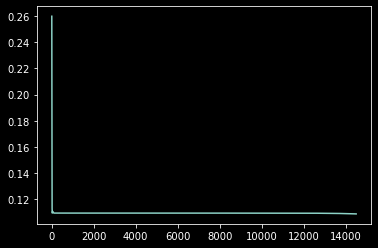

In [14]:
# Plot the losses w.r.t. epoch
plt.plot(losses)

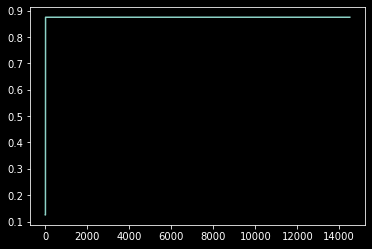

In [15]:
# Plot testing accuracies w.r.t. epoch
plt.plot(accuracies)

In [16]:
# Inspect learned parameters
with th.no_grad():
    for param in model.parameters():
        print(param.detach().clone())

tensor([[-0.1818,  0.6458,  0.8567,  0.9234,  0.6078, -0.0940],
        [ 0.1353, -0.1895,  0.0433, -0.2374, -0.0352, -0.2161]])
tensor([ 0.2905, -0.1123])
tensor([[-0.9905, -0.2939]])
tensor([-1.0199])


In [17]:
# Print loss and accuracy for last epoch (end of training)
print(losses[-1])
print(accuracies[-1])

0.10876566916704178
0.875


In [18]:
# Print model output (discretized) for the "mirror" inputs vs. expected output
with th.no_grad():
    for mirrorlist in [
        [0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 1, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1],
        [1, 0, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1],
    ]:
        print(
            th.round_(
                model(th.tensor(mirrorlist, dtype=th.float32).to(device))
                .detach()
                .clone()
            ).item(),
            mirrsymm(mirrorlist),
            "\n",
        )

0.0 1.0 

0.0 1.0 

0.0 1.0 

0.0 1.0 

0.0 1.0 

0.0 1.0 

0.0 1.0 

0.0 1.0 

